In [ ]:
import numpy as np
import tensorflow as tf

# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 

import ipysh

%aimport models.base

import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

%aimport Dataset_QSH

%aimport models.AEFIT4
%aimport models.AEFIT5
%aimport models.Compose

# ipysh.Bootstrap_support.debug()

# TEST QSH


In [58]:
qsh = Dataset_QSH.Dataset_QSH()
import os
file = ipysh.abs_builddir+'/te_db_r15.npy'
if os.path.isfile(file):
    qsh.load(file)
else:
    qsh.load(ipysh.abs_builddir+'/te_db_2.npy')
    qsh.rebalance_prel(15)
    qsh.save(ipysh.abs_builddir+'/te_db_r15.npy')
    
qsh.shuffle()
qsh.clean_up_poorcurves(5)
qsh.dim = None
qsh.set_null(np.nan)
qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F','absBt_rm'])
# qsh.unbias_mean(0.5, 'te')
# qsh.set_normal_positive()
# qsh.clip_values(0.1,0.6)

print("QSH rebalanced 15 points size: ", len(qsh))

QSH rebalanced 15 points size:  47567


In [60]:
def _map(xy,t,s):
    # xy = tf.concat([x,y], axis=0)
    # t = tf.random.normal([2],mean=0.5, stddev=0.2)
    # t = tf.clip_by_value(t, clip_value_min=0., clip_value_max=1.)
    #     smod,sarg = tf.split(s, num_or_size_splits=2, axis=0)
    #     re, im    = smod * (tf.cos(sarg), tf.sin(sarg))
    #     s = tf.concat([re,im], axis=0)
    return (xy,t,s),(xy,t,s)
# ds = qsh.tf_tuple_compose(['prel','te','tbordo~tcentro~Ip~NS~VT~F','absBt_rm~argBt_rm']).map(lambda x,y,t,s: (_map(x,y,t,s)) )
# ds = qsh.tf_tuple_compose(['prel~te:15','tbordo~tcentro~Ip~NS~VT~F','absBt_rm~argBt_rm']).map(lambda x,y,z: ((x,y,z),(x,y,z)))
ds = qsh.tf_tuple_compose(['prel~te:15','tbordo~tcentro~Ip~NS~VT~F','Bt']).map(lambda x,y,z: ((x,y,z),(x,y,z)))
[x for x in ds.batch(2).take(1)][0]

((<tf.Tensor: id=122644, shape=(2, 30), dtype=float32, numpy=
  array([[0.02923839, 0.10359484, 0.15193889, 0.2088925 , 0.27474985,
          0.34892136, 0.42965516, 0.51404023, 0.59842545, 0.6791592 ,
          0.7533307 , 0.81918806, 0.8761417 , 0.92448574, 0.96503896,
          0.15385143, 0.18000965, 0.20395252, 0.21761149, 0.25009662,
          0.25743434, 0.26593593, 0.27215624, 0.27120385, 0.2614982 ,
          0.2541982 , 0.2371419 , 0.23440257, 0.22467522, 0.20339555],
         [0.02827343, 0.10277789, 0.15121816, 0.20828514, 0.27427357,
          0.3485927 , 0.42948723, 0.51404023, 0.59859335, 0.6794879 ,
          0.75380695, 0.8197954 ,        nan,        nan, 0.96593666,
          0.16688667, 0.20140605, 0.22696789, 0.2199681 , 0.24461699,
          0.2526117 , 0.26061994, 0.2697237 , 0.27613774, 0.2787423 ,
          0.25442   , 0.24112628,        nan,        nan, 0.21159257]],
        dtype=float32)>,
  <tf.Tensor: id=122645, shape=(2, 6), dtype=float32, numpy=
  array([

In [69]:
m1 = models.AEFIT5.AEFIT5(latent_dim=10, feature_dim=30,  dprate=0., scale=2, geometry=[20,20,10,10], beta=0.) #beta=0.001)
m1.load('step10_qsh_fit5_l10')
m2 = models.AEFIT5.AEFIT5(latent_dim=6, feature_dim=6,  dprate=0., scale=1, beta=0., name='temp', geometry=[]) # parameters
m3 = models.AEFIT5.AEFIT5(latent_dim=20, feature_dim=20,  dprate=0., scale=1, beta=0., name='temp', geometry=[]) # spectrum
m3.compile( loss=tf.keras.losses.mean_squared_error )
# m2i = tf.keras.Sequential([ tf.keras.layers.InputLayer(input_shape=(6,)) ])
# m2i.compile( optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.mean_absolute_error )
hm_feature_dim = m1.latent_dim + m2.latent_dim + m3.latent_dim
hm = models.AEFIT5.AEFIT5(latent_dim=20, feature_dim=hm_feature_dim, beta=0., scale=1, name='hidden', geometry=[20,20,10])

AEFIT5 ready:
AEFIT5 ready:
AEFIT5 ready:
AEFIT5 ready:


In [70]:
h = models.Compose.Compose().set_model(hm).compose([m1,m2,m3])
m1.trainable = False
m2.trainable = False
m3.trainable = False
hm.trainable = True
h.compile()

[(None, 30), (None, 6), (None, 20)]


In [71]:
models.base.train_thread(h, ds, epoch=12, batch=100, learning_rate=1e-3, callbacks=[]).control_panel()
# h.fit(ds.batch(100), epochs=6)

Epoch 1/12
     48/Unknown - 5s 112ms/step - loss: nan - output_1_loss: nan - output_2_loss: nan - output_3_loss: nan

Exception in thread async train:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/andrea/devel/rfx/rfx-hunch/build/conf/python/site-packages/lib/python3.6/site-packages/nbmultitask.py", line 148, in run
    fn(*self._args,**self._kwargs)
  File "/home/andrea/devel/rfx/rfx-hunch/src/Tprofile_read/models/base.py", line 203, in <lambda>
    fn = lambda thread_print: train(model, data, **kwargs)
  File "/home/andrea/devel/rfx/rfx-hunch/src/Tprofile_read/models/base.py", line 193, in train
    history = model.fit(data, epochs=epoch, callbacks=callbacks + tensorboard_log(log_name), verbose=1)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py", line 643, in fit
    use_multiprocessing=use_multiprocessing)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_generator.py", line 694, in fit
    steps_name='steps_per_epoch')
  File "/usr

In [ ]:
p = Hplt.LSPlotBokeh()
p.set_model(h)
p.set_data(qsh, feed_data=ds, counts=1000)
p.plot(notebook_url='http://172.17.0.2:8888')

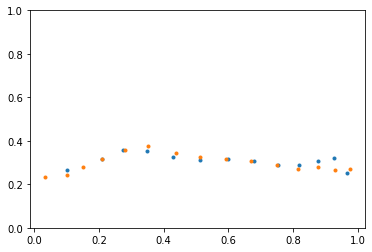

In [56]:
# [ v.name for v in h2.trainable_variables ]
def plot(xy):
    plt.figure('data')
    ax = plt.gca()
    ax.set_ylim(0.,1.)
    x,y = tf.split(xy[0], num_or_size_splits=2)
    plt.plot(x,y,'.')
d = [x for x in ds.shuffle(1000).batch(1).take(100)][0]
d0 = d[0][0]
y0 = h(d[0], training=False)
y0 = tf.sigmoid(y0[0])
plot(d0)
plot(y0)



In [ ]:
fig = plt.figure('test_curve',figsize=(18, 6))
plt.clf()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)    
# ax1.set_xlim(-2.,2.)
ax2.set_ylim(0.,1.)

sx = []
sy = []
for xy in ds.batch(1).take(1000):
    xy,_ = xy
    x,y = tf.split(xy[0],2, axis=1)
    me,_  = h.encode(xy, training=False)
    gpt = me[0].numpy()
    #ax1.scatter(gpt[0],gpt[1])
    sx.append(gpt[0])
    sy.append(gpt[1])

ax1.scatter(sx,sy)
    
for xy in ds.shuffle(100).batch(1).take(1):    
    xy,_ = xy
    x,y = tf.split(xy[0],2, axis=1)
    ax2.scatter(x,y,s=80)
    me,_  = h.encode(xy, training=False)
    gpt = me[0].numpy()
    ax1.scatter(gpt[0],gpt[1])
    
    XY = h.decode(me, training=False)[0]
    XY = tf.sigmoid(XY)
    X,Y = tf.split(XY[0], num_or_size_splits=2)
    X,Y = (X.numpy(), Y.numpy())
    ax2.scatter(X,Y,s=40)

print(qsh_pos)    
qsh_pos += 1

In [ ]:
xy,_ = [x for x in ds.batch(2).take(1)][0]
me,va = h.encode(xy)
XY = h.decode(me, apply_sigmoid=True)
XY[0][0]